In [25]:
import itertools
import os
from datetime import datetime

import cv2
import keras.src.saving.saving_api
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import Callback, ModelCheckpoint

In [26]:
data_dir = 'data/sign_data'
train_dir = f'{data_dir}/train'
test_dir = f'{data_dir}/test'

train_df = pd.read_csv(f"{data_dir}/train_data.csv", header=None)
test_df = pd.read_csv(f"{data_dir}/test_data.csv", header=None)
train_df.columns = ["orig_path", "comp_path", "is_forg"]
test_df.columns = ["orig_path", "comp_path", "is_forg"]

metrics = ['accuracy', 'precision', 'recall', 'auc']

In [27]:
train_df.head()

,orig_path,comp_path,is_forg
0,068/09_068.png,068_forg/03_0113068.PNG,1
1,068/09_068.png,068_forg/01_0124068.PNG,1
2,068/09_068.png,068_forg/02_0124068.PNG,1
3,068/09_068.png,068_forg/01_0113068.PNG,1
4,068/09_068.png,068_forg/04_0124068.PNG,1


In [11]:
filenames = pd.concat([train_df.orig_path, train_df.comp_path, test_df.orig_path, test_df.comp_path], axis=0).unique()
images = {}

_dir = train_dir

height, width = 224, 224
shape = (height, width)
for filename in filenames:
    image = cv2.imread(f'{_dir}/{filename}', cv2.IMREAD_GRAYSCALE)
    try:
        image = cv2.resize(image, shape)
    except Exception as e:
        print(f'ERROR: {_dir}/{filename}')
        raise e

    image = image.reshape(shape)
    image = np.asarray(image, dtype=np.float16)
    images[filename] = image

In [ ]:
len(images)

In [28]:
class DataLoader:
    def __init__(self, dataset: pd.DataFrame, batch_size: int, images: dict, shape: (int, int)):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shape = shape
        self.images = images

    def shuffle(self):
        return self.dataset.sample(frac=1)

    def generate(self):
        num_samples = len(self.dataset)
        while True:
            self.dataset = self.shuffle()
            for batch_begin in range(0, num_samples, self.batch_size):
                batch = self.dataset[batch_begin:batch_begin + self.batch_size]
                origs = np.array([self.images[i] for i in batch['orig_path']], dtype=np.float32)
                comps = np.array([self.images[i] for i in batch['comp_path']], dtype=np.float32)
                is_forgs = np.expand_dims(np.asarray(batch['is_forg']), axis=1)
                not_forgs = np.expand_dims(-(np.asarray(batch['is_forg']) - 1), axis=1)
                y = np.concatenate((not_forgs, is_forgs), axis=1)
                yield (origs, comps), y

In [34]:
from tensorflow.keras import layers, losses, metrics, optimizers
from tensorflow.keras import Model
from tensorflow.keras import ops

x1 = layers.Input(shape=shape)
x2 = layers.Input(shape=shape)
# параллельная модель
inputs = layers.Input(shape=shape)
feature = layers.Conv1D(16, 3, activation='relu')(inputs)
feature = layers.MaxPooling1D(2)(feature)
feature = layers.Conv1D(32, 3, activation='relu')(feature)
feature = layers.MaxPooling1D(2)(feature)
feature = layers.Conv1D(64, 3, activation='relu')(feature)
feature = layers.MaxPooling1D(2)(feature)
feature = layers.Conv1D(128, 3, activation='relu')(feature)
feature = layers.MaxPooling1D(2)(feature)
feature_model = Model(inputs=inputs, outputs=feature)

x1_net = feature_model(x1)
x2_net = feature_model(x2)
net = layers.Subtract()([x1_net, x2_net])
net = layers.Conv1D(128, 3, activation='relu')(net)
net = layers.MaxPooling1D(2)(net)
net = layers.Flatten()(net)
net = layers.Dense(512, activation='relu')(net)
net = layers.Dense(2, activation='sigmoid')(net)

classifier = Model(inputs=[x1, x2], outputs=net)
classifier.compile(loss=losses.BinaryCrossentropy(),
                   optimizer=optimizers.Adam(), metrics=['accuracy', Precision(), Recall(), AUC()])
classifier.summary()
classifier

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 224, 224)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 12, 128)   │     43,248 │ input_layer_3[0]… │
│ (Functional)        │                   │            │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_1          │ (None, 12, 128)   │          0 │ functional_5[0][… │
│ (Subtract)          │                   │            │ functional_5[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 10, 128)   │     49,280 │ subtract_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 5, 128)    │          0 │ conv1d_9[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 640)       │          0 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    328,192 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2)         │      1,026 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 421,746 (1.61 MB)

 Trainable params: 421,746 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

<Functional name=functional_7, built=True>

In [30]:
checkpoint_filepath = './checkpoints/best/signatures_binCE_e15.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1,
    save_freq='epoch'
)

In [31]:
batch_size = 512
train_set, val_set = train_test_split(train_df, test_size=0.6)

train_loader = DataLoader(dataset=train_set, batch_size=batch_size, images=images, shape=shape)
val_loader = DataLoader(dataset=val_set, batch_size=batch_size, images=images, shape=shape)


In [35]:
epochs = 15
day_month = datetime.now().strftime('%m_%d')
model_name = f'{day_month}_e{epochs}_bincrossentropy'

history = classifier.fit(
    train_loader.generate(),
    verbose=1,
    steps_per_epoch=int(len(train_set) / batch_size),
    epochs=epochs,
    validation_data=val_loader.generate(),
    validation_steps=int(len(val_set) / batch_size),
    callbacks=[model_checkpoint_callback]
)

Epoch 1/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.5412 - auc_1: 0.5369 - loss: 2.7629 - precision_1: 0.5464 - recall_1: 0.5482
Epoch 1: val_accuracy did not improve from 0.96347
18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 792ms/step - accuracy: 0.5435 - auc_1: 0.5398 - loss: 2.7060 - precision_1: 0.5482 - recall_1: 0.5520 - val_accuracy: 0.6217 - val_auc_1: 0.6885 - val_loss: 0.6472 - val_precision_1: 0.6050 - val_recall_1: 0.7145
Epoch 2/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.7032 - auc_1: 0.7646 - loss: 0.5774 - precision_1: 0.7009 - recall_1: 0.6895
Epoch 2: val_accuracy did not improve from 0.96347
18/18 ━━━━━━━━━━━━━━━━━━━━ 13s 734ms/step - accuracy: 0.7045 - auc_1: 0.7660 - loss: 0.5763 - precision_1: 0.7028 - recall_1: 0.6897 - val_accuracy: 0.7514 - val_auc_1: 0.8167 - val_loss: 0.5262 - val_precision_1: 0.7457 - val_recall_1: 0.7498
Epoch 3/15
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.7653 - auc_1: 0.8324 - loss: 0.5053 - precision_1: 0.7529 

In [36]:
history.history.keys()

dict_keys(['accuracy', 'auc_1', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_auc_1', 'val_loss', 'val_precision_1', 'val_recall_1'])

In [37]:
is_idx = True
idx = None
custom = ['precision', 'recall', 'auc']
if is_idx:
    idx = int(list(history.history.keys())[-1].split('_')[-1])
    custom = [f'{i}_{idx}' for i in custom]
metric_names = ['loss', 'accuracy'] + custom

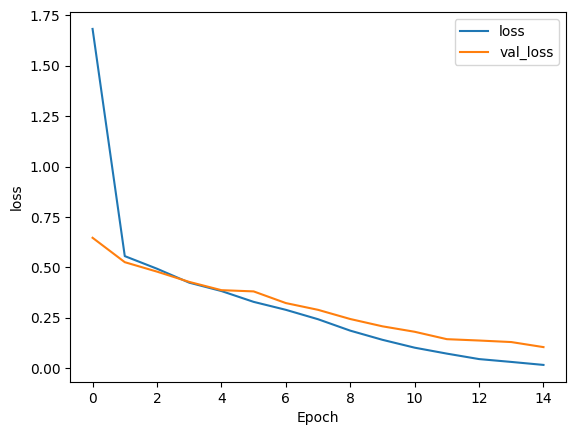

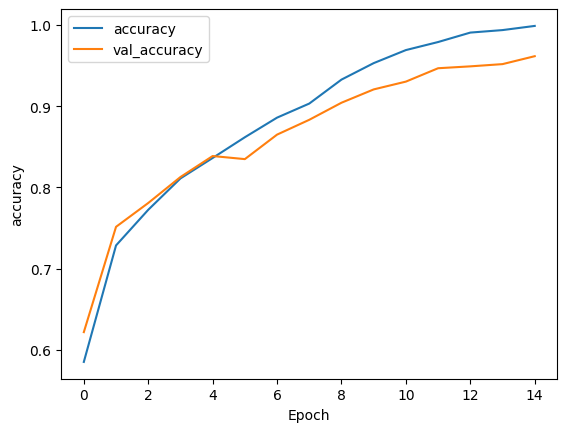

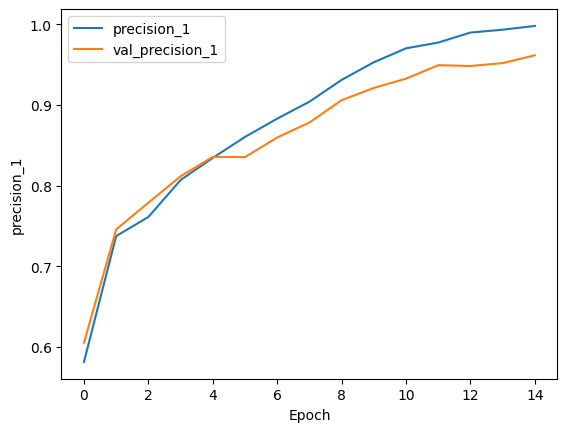

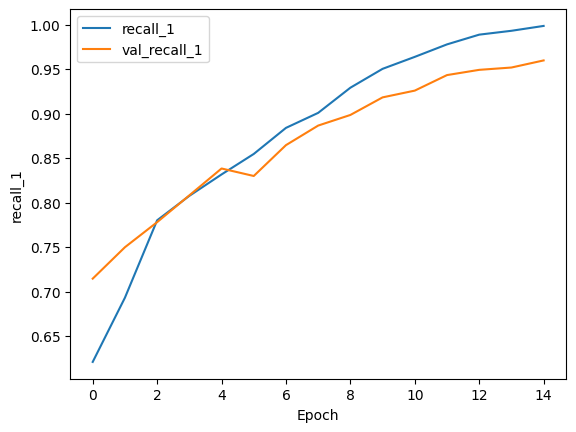

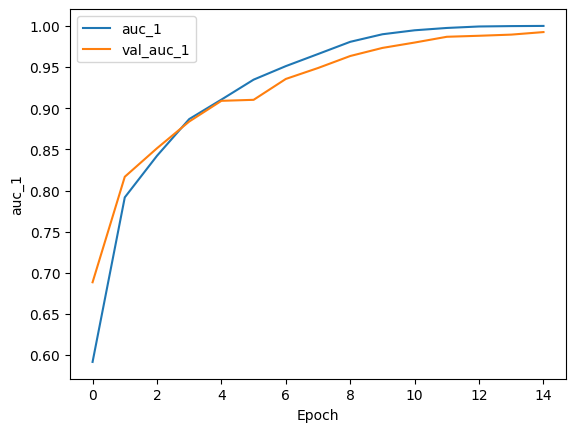

In [38]:
for m in metric_names:
    val_m = f'val_{m}'
    plt.plot(history.epoch, history.history[m], history.history[val_m])
    plt.xlabel('Epoch')
    plt.ylabel(m)
    plt.legend([m, val_m])
    plt.savefig(f'./checkpoints/plots/{model_name}_{m}.png')
    plt.show()

In [39]:
def format_evals(evals, metric_names):
    return '\n'.join([f'{name} : {val}' for name, val in zip(metric_names, evals)])


test_loader = DataLoader(dataset=test_df, batch_size=batch_size, images=images, shape=shape)
evals = classifier.evaluate(test_loader.generate(), steps=int(len(test_df) / batch_size))

print(format_evals(evals, metric_names))

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 245ms/step - accuracy: 0.9718 - auc_1: 0.9956 - loss: 0.0761 - precision_1: 0.9735 - recall_1: 0.9714
loss : 0.08044371008872986
accuracy : 0.970703125
precision_1 : 0.9718710780143738
recall_1 : 0.9692826867103577
auc_1 : 0.9950889945030212


In [100]:
classifier.save(f'./checkpoints/{model_name}.keras')
with open(f'./checkpoints/{model_name}.testmetrics.txt', 'w', encoding='utf-8') as f:
    f.writelines(format_evals(evals, metric_names))
    f.flush()

In [40]:
from tensorflow.keras.activations import softmax

def make_prediction(im1, im2):
    return np.argmax(softmax(classifier((np.expand_dims(im1, axis=0), np.expand_dims(im2, axis=0)))))

In [42]:
for i in range(150):
    sample = test_df.iloc[i]
    im1 = images[sample.orig_path]
    im2 = images[sample.comp_path]
    is_forged = sample['is_forg']
    if is_forged != make_prediction(im1, im2):
        print(i)
        continue

129
135
139


In [7]:
def plot_sample_prediction(sample):
    im1 = images[sample.orig_path]
    im2 = images[sample.comp_path]
    is_forged = sample['is_forg']

    pred = make_prediction(im1, im2)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(15)
    fig.set_figheight(10)

    title = ''
    title += f'ORIG: {sample.orig_path}\n'
    title += f'COMP: {sample.comp_path}\n\n'
    title += f'ACTUALLY: {"FORGED" if is_forged else "NOT FORGED"}\n\n'
    title += f'PREDICT: {"FORGED" if pred else "NOT FORGED"}'

    fig.suptitle(title)
    ax1.grid(False)
    ax2.grid(False)
    ax1.imshow(im1, cmap='gray')
    ax2.imshow(im2, cmap='gray')
    plt.show()

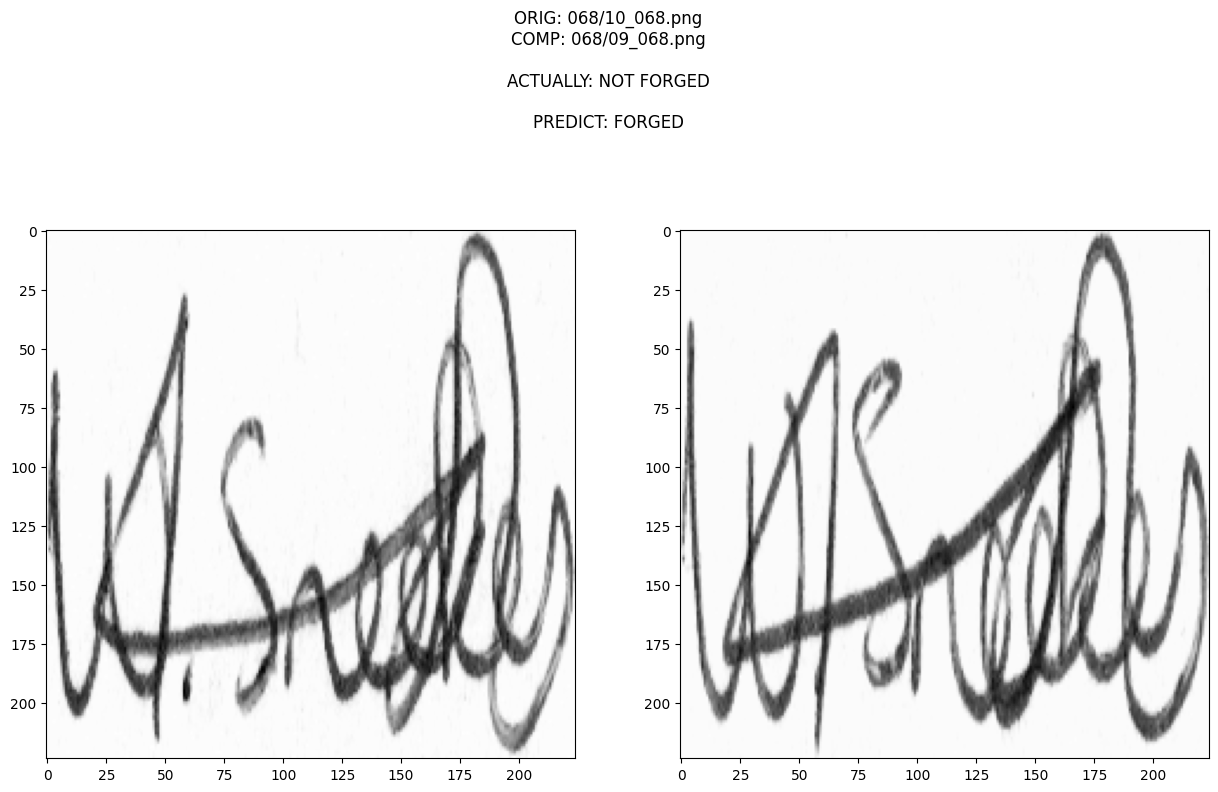

In [43]:
plot_sample_prediction(sample=test_df.iloc[129])

In [44]:
import itertools

own_images = {}

own_dir = './data/sign_data/custom'

own_origs = []
own_comps = []
own_is_forg = []
for d in os.listdir(own_dir):
    p = f'{own_dir}/{d}'
    if os.path.isfile(p):
        continue

    forgs = []
    pf = f'{p}/forg'
    for filename in os.listdir(pf):
        filepath = f'{pf}/{filename}'
        if os.path.isfile(filepath):
            forgs.append(filename)
            own_images[filename] = cv2.resize(cv2.imread(filepath, cv2.IMREAD_GRAYSCALE), shape)

    reals = []
    pr = f'{p}/real'
    for filename in os.listdir(pr):
        filepath = f'{pr}/{filename}'
        if os.path.isfile(filepath):
            reals.append(filename)
            own_images[filename] = cv2.resize(cv2.imread(filepath, cv2.IMREAD_GRAYSCALE), shape)

    for i in itertools.product(reals, reals):
        own_origs.append(i[0])
        own_comps.append(i[1])
        own_is_forg.append(0)

    for i in itertools.product(reals, forgs):
        own_origs.append(i[0])
        own_comps.append(i[1])
        own_is_forg.append(1)

own_df = pd.DataFrame({'orig_path': own_origs,
                       'comp_path': own_comps,
                       'is_forg': own_is_forg})




In [47]:
own_loader = DataLoader(own_df, 4, own_images, shape=shape)
evals = classifier.evaluate(own_loader.generate(), steps=int(len(test_df) / batch_size))

print(format_evals(evals, metric_names))

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6212 - auc_1: 0.6434 - loss: 1.7544 - precision_1: 0.6466 - recall_1: 0.6898
loss : 2.0284745693206787
accuracy : 0.6136363744735718
precision_1 : 0.6304348111152649
recall_1 : 0.6590909361839294
auc_1 : 0.62138432264328


In [48]:
with open(f'./checkpoints/{model_name}.ownmetrics.txt', 'w', encoding='utf-8') as f:
    f.writelines(format_evals(evals, metric_names))
    f.flush()